* [accepted_2007_to_2018Q4.csv] : https://www.kaggle.com/wordsforthewise/lending-club
* [LCDataDictionary.xlsx] : https://data.world/lpetrocelli/lendingclub-loan-data-2017-q-1

#Part5. [실습2] 대출 상품 투자 위험도 줄이기

## 01. 데이터 소개 및 분석프로세스 수립
 : "강의자료 → Ch04. [실습2] 대출 상품 투자 위험도 줄이기" 참고

## 02. 데이터 준비를 위한 EDA 및 전처리

In [2]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [3]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic')

### 0. 데이터 불러오기

In [4]:
############################################## 00. 필요한 파이썬 라이브러리 설치하기 #####################################################
!pip install catboost
!pip install pandas==0.25.3

In [5]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
# import re > 정규식 사용하는 라이브러리
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

In [6]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


#### 1) 대출 승인내역 불러오기
  * issue_d 컬럼은 parse_dates 사용
  * infer_datetime_format = True
  * reset_index(drop=True) 사용

In [7]:
data = pd.read_csv(
    '/Users/brianna/Downloads/archive/accepted_2007_to_2018Q4 2.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)
    # issue_d는 대출금 조달된 날(날짜 데이터)
    # infer_datetime_format=True : 이슈 D 컬럼 불러올때 datatime형식으로 불러와라
    # pandas가 똑똑하게도 알아서 날짜/시간 포맷을 추정해서 잘 파싱해줌
data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
# 2018년도 1월 1일 ~ 2019년도 1월 1일까지 데이터 가져옴
data = data.reset_index(drop=True)
# 새로가져온 데이터는 인덱스 새로 설정
data.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


#### 2) 대출용어 사전 불러오기 
* pandas 의 read_excel 사용 / Excel Sheet 중 2번째(sheet_name=1)을 불러온다.

In [8]:
browse_notes = pd.read_excel('/Users/brianna/Downloads/LCDataDictionary.xlsx',
                             engine= 'openpyxl', sheet_name=1) 
# 대출용어 사전 불러오기, sheet_name = 1 기재해야지 2번째 시트불러옴
# 없으면 첫번째 시트 디폴트로 불러옴
browse_notes.head()

,BrowseNotesFile,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,acceptD,The date which the borrower accepted the offer,NaN,NaN,NaN,NaN
1,accNowDelinq,The number of accounts on which the borrower i...,NaN,NaN,NaN,NaN
2,accOpenPast24Mths,Number of trades opened in past 24 months.,NaN,NaN,NaN,NaN
3,addrState,The state provided by the borrower in the loan...,NaN,NaN,NaN,NaN
4,all_util,Balance to credit limit on all trades,NaN,NaN,NaN,NaN


### 1. 데이터 전처리
  * 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 대출용어 사전 결측값 제거

In [9]:
browse_notes['BrowseNotesFile'].dropna().values
# drop.na 불러오면서 바로 제거 가능

array(['acceptD', 'accNowDelinq', 'accOpenPast24Mths', 'addrState',
       'all_util', 'annual_inc_joint', 'annualInc', 'application_type',
       'avg_cur_bal', 'bcOpenToBuy', 'bcUtil', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'creditPullD', 'delinq2Yrs',
       'delinqAmnt', 'desc', 'dti', 'dti_joint', 'earliestCrLine',
       'effective_int_rate', 'emp_title', 'empLength', 'expD',
       'expDefaultRate', 'ficoRangeHigh', 'ficoRangeLow', 'fundedAmnt',
       'grade', 'homeOwnership', 'id', 'il_util', 'ils_exp_d',
       'initialListStatus', 'inq_fi', 'inq_last_12m', 'inqLast6Mths',
       'installment', 'intRate', 'isIncV', 'listD', 'loanAmnt',
       'max_bal_bc', 'memberId', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mortAcc', 'msa',
       'mths_since_last_major_derog', 'mths_since_oldest_il_open',
       'mths_since_rcnt_il', 'mthsSinceLastDelinq', 'mthsSinceLastRecord',
       'mthsSinceMostRecentInq', 'mthsSinceRecentBc',

In [10]:
browse_feat = browse_notes['BrowseNotesFile'].dropna().values
# 결측값 없앤 데이터를 browse_feat으로 넣어줌

#### 2) 대출용어 사전과 대출승인 데이터 문자열 규칙 맞추기
  * 대문자, 숫자 앞에 '_' 붙여주고 모두 소문자 변환
    > re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower()
  * 공백 처리
    > .strip()

In [11]:
### ???
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]

In [12]:
browse_feat

['accept_d',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc_joint',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'credit_pull_d',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'effective_int_rate',
 'emp_title',
 'emp_length',
 'exp_d',
 'exp_default_rate',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'il_util',
 'ils_exp_d',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'is_inc_v',
 'list_d',
 'loan_amnt',
 'max_bal_bc',
 'member_id',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'msa',
 'mths_since_last_major_derog',
 'mths_since_oldest_il_open',
 'mths_since_rcnt_il',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_most_recent_inq',
 'mths_since_recent_b

#### 3) 대출승인 데이터 컬럼과 대출용어 간의 차이를 확인한다
  * np.setdiff1d(ar1, ar2) : ar2 에는 없는 ar1의 고유한 값을 반환
  * https://rfriend.tistory.com/355

In [13]:
data_feat = data.columns.values
###### 코드 작성 부분 시작 ######
np.setdiff1d(browse_feat, data_feat)
###### 코드 작성 부분 마침 ######
# !대출용어사전에만 있음!, 대출승인 데이터에는 없는 내용임

array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'open_il_6m', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U30')

In [14]:
np.setdiff1d(data_feat, browse_feat)
# 사전 데이터에는 없고, !대출승인데이터에만 있음!

array(['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term',
       'disbursement_method', 'funded_amnt_inv', 'hardship_amount',
       'hardship_dpd', 'hardship_end_date', 'hardship_flag',
       'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mo_sin_old_il_acct',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'next_pymnt_d', 'open_act_il',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'payment_plan_start_date', 'policy_code',
       'pymnt_plan', 'recoveries', 'revol_bal_joint',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_ap

#### 4) 대출 시점(대출용어 사전)에서의 용어 중 대출승인 데이터 컬럼과 같은 의미인 용어를 서로 같게 만든다
  * 대출 시점(대출용어 사전)에서의 용어 중 대출승인 데이터 컬럼과 의미가 같지만 이름이 다른 컬럼들
          ['is_inc_v', 'mths_since_most_recent_inq','mths_since_oldest_il_open','mths_since_recent_loan_delinq', 'verified_status_joint']
  * 대출승인 데이터 컬럼에서의 이름들 (예: verified_status_join → verification_status_joint)
          ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct','mths_since_recent_bc_dlq', 'verification_status_joint']
  * np.setdiff1d / np.append 사용

In [15]:
# 대출 용어 사전에 있는것들이 틀린것들임
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
# 대출 승인 데이터들이 맞는것으로 정의
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

###### 코드 작성 부분 시작 ######
broswse_feat = np.setdiff1d(browse_feat, wrong)
###### 코드 작성 부분 마침 ######
browse_feat = np.append(browse_feat, correct)

#### 5) 대출용어 사전과 대출승인 데이터 컬럼 이름이 같은 것들만 가져온다.
  * np.intersect1d(ar1, ar2) : ar1 과 ar2 의 공통된 항목들만 반환한다

In [16]:
pip install numpy==1.16.5

Note: you may need to restart the kernel to use updated packages.


In [17]:
###### 코드 작성 부분 시작 ######
avail_feat = np.intersect1d(browse_feat, data_feat)
X = data[avail_feat].copy()
X.info()
###### 코드 작성 부분 마침 ######

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Data columns (total 94 columns):
acc_now_delinq                    495242 non-null float64
acc_open_past_24mths              495242 non-null float64
addr_state                        495242 non-null object
all_util                          495113 non-null float64
annual_inc                        495242 non-null float64
annual_inc_joint                  68985 non-null float64
application_type                  495242 non-null object
avg_cur_bal                       495202 non-null float64
bc_open_to_buy                    488654 non-null float64
bc_util                           488439 non-null float64
chargeoff_within_12_mths          495242 non-null float64
collections_12_mths_ex_med        495242 non-null float64
delinq_2yrs                       495242 non-null float64
delinq_amnt                       495242 non-null float64
desc                              0 non-null object
dti                         

### 2. 데이터 타입별 Feature 변환
  * 결측값 처리
  * 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 범주형 데이터 확인
  * pandas 의 select_dtypes('object') 사용
  * https://brunch.co.kr/@brunch92ny/4

In [18]:
###### 코드 작성 부분 시작 ######
X.select_dtypes('object').head()
# select_dtypes() 범주형 데이터 인것만 가져옴!!
###### 코드 작성 부분 마침 ######

# earliest_cr_line > 대출시작한달

,addr_state,application_type,desc,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,initial_list_status,purpose,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
0,OK,Individual,NaN,Jan-2009,8 years,General Manager,D,RENT,130954621,w,other,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,FL,Individual,NaN,Jul-1998,2 years,IT Director,B,OWN,130964697,w,debt_consolidation,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,NH,Joint App,NaN,Jul-2007,< 1 year,Client services,G,RENT,130955326,w,medical,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,AL,Individual,NaN,Mar-1995,10+ years,Asphalt Supervisor,D,MORTGAGE,130504052,w,debt_consolidation,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,WA,Individual,NaN,Jan-1998,9 years,Scale Technician,A,RENT,130956066,w,major_purchase,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


#### 2) 범주형 문자열 데이터 중 날짜/기간/고유ID 데이터 처리
  * pandas 의 to_datetime 사용
  * .str.extract('(\d+)').astype('float') 사용

In [19]:
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)

In [20]:
X['emp_length'].unique()
# emp_length 근속연수임
# 숫자 , 문자, 부등호 포함되어 있음

array(['8 years', '2 years', '< 1 year', '10+ years', '9 years', nan,
       '5 years', '4 years', '1 year', '7 years', '3 years', '6 years'],
      dtype=object)

In [21]:
X['id']

0         130954621
1         130964697
2         130955326
3         130504052
4         130956066
            ...    
495237    130135401
495238    129961614
495239    130056422
495240    130065381
495241    129555354
Name: id, Length: 495242, dtype: object

In [22]:
# \d+ 정수 다음에 오는 문자들을 가져와서 float형식으로 바꿈
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')
X['id'] = X['id'].astype('float')

### 3. 결측값 처리
  * 결측값 처리
  * 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 컬럼별 결측값 비율 구한 후, 비율=1 인 컬럼 제거
  * .isna().mean()
  * 컬럼별 결측값 비율이 0 인 항목을 제외한 나머지 항목들을 pandas 의 sort_values() 사용하여 정렬
  * 비율=1 인 항목을 확인하여 pandas 의 drop 으로 제거

In [23]:
X.isna()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495237,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
495238,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
495239,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
495240,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [24]:
X.isna().mean()
# 각 컬럼별로 na개수 비율 평균

acc_now_delinq               0.000000
acc_open_past_24mths         0.000000
addr_state                   0.000000
all_util                     0.000260
annual_inc                   0.000000
                               ...   
total_rev_hi_lim             0.000000
url                          0.000000
verification_status          0.000000
verification_status_joint    0.870748
zip_code                     0.000000
Length: 94, dtype: float64

In [25]:
nan_mean = X.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean # 1이 었던 항목 제거됨

pct_tl_nvr_dlq                    0.000004
avg_cur_bal                       0.000081
all_util                          0.000260
revol_util                        0.001195
dti                               0.002286
mths_since_recent_bc              0.012515
bc_open_to_buy                    0.013303
percent_bc_gt_75                  0.013319
bc_util                           0.013737
num_tl_120dpd_2m                  0.025046
mths_since_rcnt_il                0.037174
mo_sin_old_il_acct                0.037174
emp_length                        0.084781
emp_title                         0.110368
mths_since_recent_inq             0.123788
il_util                           0.163201
mths_since_last_delinq            0.558620
mths_since_recent_revol_delinq    0.711878
mths_since_last_major_derog       0.768128
mths_since_recent_bc_dlq          0.801895
dti_joint                         0.860704
annual_inc_joint                  0.860704
verification_status_joint         0.870748
mths_since_

In [26]:
# 모두 결측값인 컬럼 제거 desc, member_id
# axis =1 > 열에 대해서 제거
X = X.drop(['desc', 'member_id'], axis=1, errors='ignore')

#### 2) 결측값 채우기
  * 범주형 데이터의 결측값은 공백('')으로 채운다
   * 값이 커졌을때 대출위험도가 커지지 않으면 -> 최대값으로 채우고, 값이 커졌을때 대출위험도가 커지면 최소값으로 채움
  * 숫자형 데이터의 결측값은 대출 데이터 특성에 따라 데이터의 최대값, 최소값으로 각각 채운다
  * 최대값으로 채우는 경우(값이 커졌을때 대출 위험도가 줄어듬> 최대값으로 채움)
            'bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq'
  * 최대값 이외에는 최소값으로 채운다

In [27]:
fill_empty = ['emp_title', 'verification_status_joint']

# 데이터 설명 시트의 빨간색 항목 참조
# 최대값으로 해서 해당 항목으로 인해 부실 대출 방향으로 판단하지 않도록 함
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq']

fill_min = np.setdiff1d(X.columns.values, np.append(fill_empty, fill_max))

X[fill_empty] = X[fill_empty].fillna('')
###### 코드 작성 부분 시작 ######
X[fill_max] = X[fill_max].fillna(X[fill_max].max())
X[fill_min] = X[fill_min].fillna(X[fill_min].min())
###### 코드 작성 부분 마침 ######

### 4. 변수 간 상관성에 따른 데이터 정제

#### 1) 숫자형 컬럼 데이터의 유일한 값 개수 확인
  * pandas 의 select_dtypes('number') 사용
  * pandas 의 nunique().sort_values() 사용
  * 유일한 값이 1개인 경우/모든 행의 값이 다른 경우 둘 다 제거한다

In [28]:
###### 코드 작성 부분 시작 ######
num_feat = X.select_dtypes('number').columns.values   
###### 코드 작성 부분 마침 ######

# id는 분석에 도움되지 않음!
# num_tl_120dpd_2m 모든 데이터가 같은 것도 필요 없음!

In [29]:
X[num_feat].nunique().sort_values()

num_tl_120dpd_2m                   1
acc_now_delinq                     2
num_tl_30dpd                       2
inq_last_6mths                     6
pub_rec_bankruptcies               8
                               ...  
total_il_high_credit_limit    128691
total_bal_ex_mort             139900
tot_cur_bal                   254794
tot_hi_cred_lim               266282
id                            495242
Length: 77, dtype: int64

In [30]:
X = X.drop(['num_tl_120dpd_2m', 'id'], axis=1, errors='ignore')

#### 2) 숫자형 데이터 상관도에 따른 컬럼 제거
  * 숫자형 컬럼들 간 Pearson R 상관 계수를 구한다
  * 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼을 제거해 본다
  * 컬럼들 간 조합 생성 : comb_num_feat = np.array(list(combinations(num_feat, 2)))
  * Pearson R 상관 계수 구하기 : pearsonr(x1, x2)[0]

In [31]:
num_feat = X.select_dtypes('number').columns.values
# (num_feat, 2) > 숫자형 데이터 타입의 모든 컬럼들의 값들의 집합 2개씩 뽑은 조합들을 리스트화시킨것을 연결해달라
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    ###### 코드 작성 부분 시작 ######
    corr = pearsonr(X[comb[0]], X[comb[1]])[0]
    ###### 코드 작성 부분 마침 ######
    corr_num_feat = np.append(corr_num_feat, corr)

In [32]:
###### 코드 작성 부분 시작 ######
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
# np.abs()> 절대값 
###### 코드 작성 부분 마침 ######
high_corr_num

array([['acc_now_delinq', 'num_tl_30dpd'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['mo_sin_old_il_acct', 'mths_since_rcnt_il'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_ex_mort', 'total_bal_il'],
       ['total_bal_il', 'total_il_high_credit_limit']], dtype='<U30')

In [33]:
# 가장 큰값은 제거함
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

#### 3) 범주형 데이터의 유일한 값 개수 확인
  * pandas 의 select_dtypes('object') 사용
  * pandas 의 nunique().sort_values() 사용
  * 유일한 값이 1개인 경우/모든 행의 값이 다른 경우 둘 다 제거한다
  * 범주형 데이터의 경우 Encoding 시 메모리 오류를 방지하기 위해 유일한 값이 많은 경우는 제거하는 것이 좋다

In [34]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                  2
initial_list_status               2
term                              2
verification_status               3
home_ownership                    4
verification_status_joint         4
grade                             7
title                            12
purpose                          13
sub_grade                        35
addr_state                       50
zip_code                        897
emp_title                    129450
url                          495242
dtype: int64

In [35]:
# emp_title, url 범주형 데이터 활용도 낮은컬럼 2개 제거
X = X.drop(['url', 'emp_title'], axis=1, errors='ignore')

#### 4) 범주형 데이터 상관도에 따른 컬럼 제거
  * 범주형 컬럼들 간 카이제곱 통계량을 사용하는 Crammer 의 V 상관 계수를 구한다
  * Crammer 의 V 상관계수 식 구하는 방법


```
  table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
  corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
```


  * 상관 계수가 0.9 이상인 컬럼들 중 머신러닝 모델 생성 시 예측 변수의 조건으로 활용할 grade 를 제외한 후 가장 높은 컬럼을 제거한다.
  * 컬럼들 간 조합 생성 : comb_cat_feat = np.array(list(combinations(cat_feat, 2)))

In [36]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

In [37]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

array([['addr_state', 'zip_code'],
       ['application_type', 'verification_status_joint'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

In [38]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

### 5. 예측 변수 Feature 생성

#### 대출 상태를 보여주는 'loan_status' 를 예측 변수 Feature 로 한다
  * loan_status 의 항목별 개수를 확인한다
  * 건전한 상태를 나타내는 'Current, Fully Paid, In Grace Period' 를 1 로 나타낸다.
  * 그 외는 부실한 상태를 나타내는 0 으로 나타낸다.

In [39]:
data['loan_status'].value_counts()

Current               427181
Fully Paid             47444
Charged Off             8867
Late (31-120 days)      7221
In Grace Period         2919
Late (16-30 days)       1603
Default                    7
Name: loan_status, dtype: int64

In [40]:
y = data['loan_status'].copy()
y = y.isin(['Current', 'Fully Paid', 'In Grace Period']).astype(int)
# y에 isin'Current', 'Fully Paid', 'In Grace Period' 가 포함되어 있다면 True(1) , 아니면 False(0)
y.value_counts()

1    477544
0     17698
Name: loan_status, dtype: int64

## 03. 모델링

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Data columns (total 74 columns):
acc_open_past_24mths              495242 non-null float64
addr_state                        495242 non-null object
all_util                          495242 non-null float64
annual_inc                        495242 non-null float64
annual_inc_joint                  495242 non-null float64
application_type                  495242 non-null object
avg_cur_bal                       495242 non-null float64
bc_open_to_buy                    495242 non-null float64
bc_util                           495242 non-null float64
chargeoff_within_12_mths          495242 non-null float64
collections_12_mths_ex_med        495242 non-null float64
delinq_2yrs                       495242 non-null float64
delinq_amnt                       495242 non-null float64
dti                               495242 non-null float64
dti_joint                         495242 non-null float64
earliest_cr_line     

#### 1) 분석 목표는 '고위험/고금리 대출 중 양호한 대출을 예측하는 것'
  * 위험도를 나타내는 grade 컬럼에서 가장 위험한 상태인 'E' 에 해당하는 데이터만 가져온다.
  * 위험도에 따라 설정되는 int_rate 컬럼은 제거한다.
  * 'A' 해당하는 데이터는 위험도가 낮은것임

In [41]:
# 위험한 등급만 해당되는 X_mod에 변수저장
X_mod = X[X.grade == 'E'].copy()
# grade에 따라서 int_rate 자동적으로 따라가서 제거함
# axis = 열삭제
X_mod = X_mod.drop(['grade', 'int_rate'], axis=1, errors='ignore')
y_mod = y[X_mod.index]### X_mod인덱스에 따라서 Y_mod도 같이 변해야함

In [63]:
X_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18958 entries, 53 to 495211
Data columns (total 72 columns):
acc_open_past_24mths              18958 non-null float64
addr_state                        18958 non-null object
all_util                          18958 non-null float64
annual_inc                        18958 non-null float64
annual_inc_joint                  18958 non-null float64
application_type                  18958 non-null object
avg_cur_bal                       18958 non-null float64
bc_open_to_buy                    18958 non-null float64
bc_util                           18958 non-null float64
chargeoff_within_12_mths          18958 non-null float64
collections_12_mths_ex_med        18958 non-null float64
delinq_2yrs                       18958 non-null float64
delinq_amnt                       18958 non-null float64
dti                               18958 non-null float64
dti_joint                         18958 non-null float64
earliest_cr_line                  18

In [56]:
y_mod

53        1
61        1
102       1
110       1
118       1
         ..
495066    0
495100    1
495151    1
495160    1
495211    1
Name: loan_status, Length: 18958, dtype: int64

  * 훈련 데이터와 테스트 데이터를 먼저 나눈다
  * 모델링에 사용할 훈련/검증 데이터를 그 이후에 나눈다
  * https://yeko90.tistory.com/entry/what-is-stratify-in-traintestsplit

In [42]:
# stratify = y_mod > y_mod 클래스 분포 비율에 따라 맞춤
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

#### 2) 머신러닝 기법은 'CatBoost' 를 사용한다.
  * CatBoost 는 범주가 많은 범주형 Feature 를 포함하는 데이터셋에 매우 효율적이다.
  * CatBoost 는 범주형 데이터를 숫자형으로 변환하게 되고, 기본 설정으로 Mean Encoding 을 사용하는데 단순하게 평균을 사용하게 되면 Data Leakage 문제(우리가 예측해야 하는 값이 훈련 데이터의 Feature 에 들어가는 문제) 가 나타나게 되는데 이전 데이터들의 평균을 활용하는 방법을 사용하여 이를 해결해 준다
  * Pool 을 사용하여 학습 데이터를 CatBoost 에 맞게 변환해 준다
  * CatBoost 는 Ordered Boosting 과 Random Permutation 등의 Overfitting 을 방지하기 위한 내장 알고리즘이 있어서, 비교적 다른 Gradient Boosting 방법들에 비해 Hyper Parameter Tuning 에 자유로운 알고리즘
  * https://dailyheumsi.tistory.com/120

In [1]:
cat_feat_ind = (X_train.dtypes == 'object').nonzero()[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
###### 코드 작성 부분 시작 ######
# verbose 함수 수행시 발생하는 상세 정보 표시여부
model = CatBoostClassifier(learning_rate = 0.03, 
                           verbose = False, 
                           random_state=0)
###### 코드 작성 부분 마침 ######
model.fit(pool_train, eval_set = pool_val, plot=True)

NameError: name 'X_train' is not defined

#### 3) 모델 평가
  * Accuracy, Precision, Recall 을 사용한다
  * Accuracy(정확도) : (실제 데이터가 예측 데이터인 수) / (전체 데이터 수) → 모델이 얼마나 정확하게 분류하는가?
  * Precision(정밀도) : (A라고 예측한 데이터가 실제 A인 데이터 수) / (A라고 예측한 데이터 수) → 모델이 찾은 A는 얼마나 정확한가? "일반 메일을 스팸 메일로 분류해서는 안된다"
  * Recall(재현율) : (A라고 예측한 데이터 수) / (실제 A인 데이터 수) → 모델이 얼마나 정확하게 A를 찾는가? "실제 암환자인 경우 반드시 양성으로 판단해야 한다"
  * https://yeko90.tistory.com/entry/%EB%A8%B8%EC%8B%A0-%EB%9F%AC%EB%8B%9D-%EA%B8%B0%EC%B4%88-%EC%A0%95%EB%B0%80%EB%8F%84Precision-%EC%9E%AC%ED%98%84%EC%9C%A8Recall-%EA%B0%9C%EB%85%90

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


Accuracy (test): 0.909
Precision (test): 0.909
Recall (test): 1.000


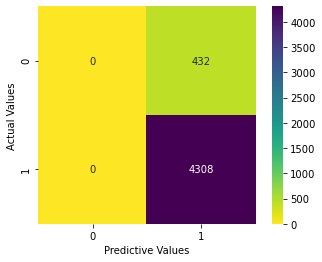

In [47]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

###### 코드 작성 부분 시작 ######
cm = confusion_matrix(y_test, y_pred_test)
###### 코드 작성 부분 마침 ######
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predictive Values')
ax.set_ylabel('Actual Values');

## 04. Feature Importances

#### 1) Feature Importances 그래프 그리기

In [50]:
model.feature_names_

['acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'fico_range_low',
 'home_ownership',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'loan_amnt',
 'max_bal_bc',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'open_acc_

In [49]:
model.feature_importances_

array([0.73703484, 4.30077357, 1.86682089, 1.85557071, 2.36084602,
       0.10741073, 0.56538429, 1.91654151, 1.29439395, 0.31460168,
       0.06024143, 0.79222281, 0.02959255, 1.39056067, 0.85858202,
       1.59111733, 2.18089326, 1.26576655, 0.85848299, 1.11667995,
       2.16192132, 0.43746733, 2.38725193, 2.56043208, 9.58927322,
       1.54602496, 2.24785243, 0.66332153, 0.82255255, 1.09796782,
       1.61985972, 1.11394995, 1.57908052, 1.04762705, 0.6472417 ,
       1.10175518, 5.10749169, 0.9469049 , 0.27511532, 1.20799178,
       0.94439161, 1.02727717, 1.67795299, 1.99868995, 1.02979406,
       1.83969753, 0.        , 0.63958854, 0.57428537, 0.9282611 ,
       0.68274631, 0.85573721, 0.40296126, 0.38791974, 0.73879815,
       1.16993591, 1.56672235, 0.18621971, 0.13663997, 1.87212925,
       1.36328367, 2.3002603 , 0.25163789, 3.96872956, 0.98787348,
       1.42668956, 0.97617889, 1.65484195, 0.47678895, 1.54618319,
       1.63090924, 1.13227439])

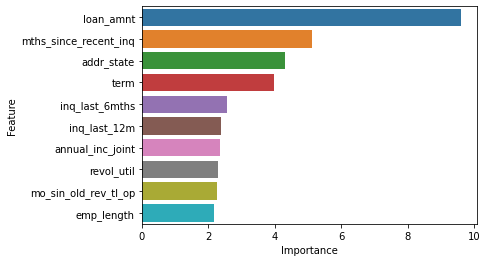

In [48]:
feat = model.feature_names_
###### 코드 작성 부분 시작 ######
imp = model.feature_importances_
###### 코드 작성 부분 마침 ######
# dataframe 하나 만들고,
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
# dataframe을 importance순으로 상위 10개만 반환
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);
# 고위험, 고금리 대출 양호도를 판단하는데 가장 잘 나타나변수1)대출금액, 2) 최근 대출 문의 3) 대출시청시 대출 차용인이 제공한 상태
# 4) term 대출을 하고나서 대출 지급 회수, 5) 지난 6개월간 문의 건수

#### 2) 주요 3개 Feature 와 건전/부실 대출 간 관계

* 대출액 히스토그램 상에서의 건전/부실 대출

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


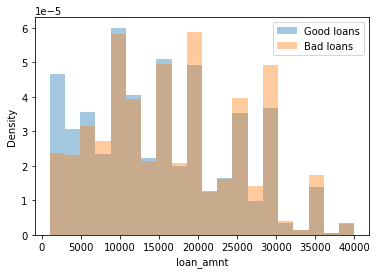

In [51]:
good = X_mod.loc[y_mod == 1, 'loan_amnt']
bad = X_mod.loc[y_mod == 0, 'loan_amnt']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

# 대출금액이 적은것들에 good그룹이 다 몰려있음, 대출 많은 것들에는 bad그룹이 몰려있음

* 가장 최근에 대출 문의한 기간 히스토그램 상에서의 건전/부실 대출

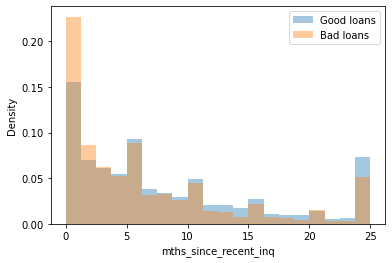

In [52]:
good = X_mod.loc[y_mod == 1, 'mths_since_recent_inq']
bad = X_mod.loc[y_mod == 0, 'mths_since_recent_inq']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();
# 최근에 대출을 문의하고 얼마나 지났는지? 1개월만에 다시 문의한사람이 양호하지 못한 대출을 가지고 있음

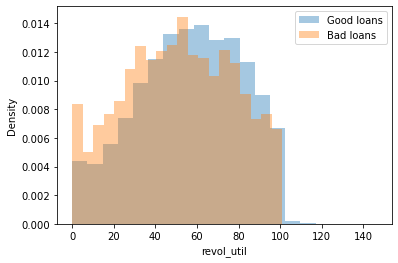

In [54]:
good = X_mod.loc[y_mod == 1, 'revol_util']
bad = X_mod.loc[y_mod == 0, 'revol_util']
# 리볼빙 신용에 대해서 대출자가 사용중인 신용금액: 몇개월 동안 나눠갚는 형식의 회전율
bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();